In [1]:
from pandas import read_csv, DataFrame
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, rdFingerprintGenerator
from rdkit.Chem import Draw
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from numpy import sqrt, array
import shap
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdCoordGen import AddCoords as addcord
from warnings import filterwarnings
from random import seed
import optuna
import pickle
filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
seed(0)
data = read_csv('../../../DATABASE/no_missing_data.csv')
data

,molecule,smiles,max_abs,max_em,solvent,dc,etn
0,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,620.0,DMSO,46.8260,0.444
1,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,565.0,H2O,78.3553,1.000
2,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,575.0,AcOEt,6.0200,0.228
3,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,450.0,615.0,DCM,8.9300,0.309
4,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,615.0,ACN,35.6880,0.460
...,...,...,...,...,...,...,...
696,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,380.0,536.0,DCM,8.9300,0.309
697,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,374.0,549.0,ACN,37.5000,0.460
698,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,376.0,570.0,DIOX,2.2500,0.164
699,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,377.0,560.0,DCM,8.9300,0.309


In [ ]:
# seed(0)

# NamesMol = data['molecule']
# SolventMol = data['solvent']

In [ ]:
def prepare_data(data):
    PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
    radius = 4
    fp_size = 2048
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fp_size)
    morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]
    morgan_df = DataFrame(morgan_fps)
    morgan_df.columns = ['MF_' + str(j + 1) for j in morgan_df.columns]
    
    morgan_df['etn'] = data['etn'].to_numpy()

    X_fps = morgan_df.to_numpy()
    y_fps = data['max_em'].to_numpy()
    
    return X_fps, y_fps

def evaluate_random_state(random_state, X, y):
    model_fps = XGBRegressor(random_state=42, n_jobs=-1)
    cv_fps = KFold(n_splits=10, shuffle=True, random_state=random_state)
    scores_fps = cross_val_score(model_fps, X, y, scoring='r2', cv=cv_fps, n_jobs=-1).mean()
    return scores_fps, random_state

def find_best_random_state(data, n_states=100):
    X_fps, y_fps = prepare_data(data)
    
    best_score = float('-inf')
    best_random_state = None
    
    print("Random State | Mean R2 Score")
    print("-" * 30)
    
    for random_state in range(n_states):
        score, _ = evaluate_random_state(random_state, X_fps, y_fps)
        print(f"{random_state:12d} | {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_random_state = random_state
    
    print("-" * 30)
    print(f"Best random state: {best_random_state}")
    print(f"Best mean R2 score: {best_score:.4f}")
    
    return best_random_state, best_score

# Usage
np.random.seed(0)
best_random_state, best_score = find_best_random_state(data)

best random_state for abs KFold: 4

best random_state for em KFold: 23 

In [3]:
seed(0)

np.random.seed(0)


PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
        # Create the fingerprint generator
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 4, fpSize = 2048)

# Generate fingerprints for each molecule
morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]

morgan_df = DataFrame(morgan_fps)

morgan_df.columns = ['MF_' + str(j+1) for j in morgan_df.columns]
morgan_df['etn'] = data['etn'].to_numpy()

# morgan_df['max_abs'] = data['max_abs'].to_numpy()
# morgan_df['max_em'] = data['max_em'].to_numpy()
# morgan['dc'] = data['dc'].values
morgan_df

,MF_1,MF_2,MF_3,MF_4,MF_5,MF_6,MF_7,MF_8,MF_9,MF_10,...,MF_2040,MF_2041,MF_2042,MF_2043,MF_2044,MF_2045,MF_2046,MF_2047,MF_2048,etn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.444
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.228
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.164
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309


In [ ]:
seed(0)
np.random.seed(0)
test = {}

def objective(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    #     'max_depth': trial.suggest_int('max_depth', 3, 10),
    #     'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
    #     'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    #     'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    #     'gamma': trial.suggest_int('gamma', 0, 5),
    #     'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
    #     'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    #     'n_jobs': -1,
    #     'objective': 'reg:squarederror'
    # }
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
    'max_depth': trial.suggest_int('max_depth', 4, 8),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
    'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
    'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    }

    model = XGBRegressor(**params, random_state=42)
    cv = KFold(n_splits=10, shuffle=True, random_state=23)

    x_kf = morgan_df.to_numpy()
    y_kf = data['max_em'].to_numpy()

    mse_scores = cross_val_score(model, x_kf, y_kf, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    r2_scores = cross_val_score(model, x_kf, y_kf, scoring='r2', cv=cv, n_jobs=-1)
    
    mean_mse = -mse_scores.mean()
    mean_r2 = r2_scores.mean()

    test.update({'trial':trial, 'mse':mean_mse, 'r2':mean_r2})

    return mean_mse, mean_r2


study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(objective, n_trials=100)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
for i in study.best_trials:
    print(i.params)
    print(i.values)

In [16]:
seed(0)
np.random.seed(0)
# param_abs = {'n_estimators': 522, 'max_depth': 8, 'learning_rate': 0.028564819211536967, 'subsample': 0.8383756107911184, 'colsample_bytree': 0.720080324874693, 'gamma': 0.001754742159327034, 'reg_alpha': 7.710396015328691e-05, 'reg_lambda': 0.09953515181829936, 'min_child_weight': 4}
param_em = {'n_estimators': 502, 'max_depth': 7, 'learning_rate': 0.033074940339811634, 'subsample': 0.7929425121425856, 'colsample_bytree': 0.7202566808952925, 'gamma': 2.069940949919729e-06, 'reg_alpha': 2.154432443846662e-06, 'reg_lambda': 0.00010795822680859202, 'min_child_weight': 5}

model_pred = XGBRegressor(**param_em, n_jobs=-1, random_state=42)

X = morgan_df.to_numpy()
Y = data['max_abs'].to_numpy()

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

kfold = KFold(n_splits=10, random_state=23, shuffle=True) #23 abs, 4 em

In [17]:
seed(0)
np.random.seed(0)
for score in scoring:
    if 'neg' in score:     
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        if 'squared' in score:
            scores = [sqrt(-x) for x in scores]
        else:
            scores = [-x for x in scores]
        mean_scores = np.mean(scores)
        std_scores = np.std(scores)
        print('{}: {:.4f}+-{:.4f}'.format(score, mean_scores, std_scores))

    else:
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        print('{}: {:.4f}+-{:.4f}'.format(score, scores.mean(), scores.std()))

r2: 0.8543+-0.0904
neg_mean_squared_error: 18.5632+-9.2817
neg_mean_absolute_error: 8.9700+-1.8467


**For max_abs**

r2: 0.8976+-0.1075

neg_mean_squared_error: 14.9539+-8.4224

neg_mean_absolute_error: 7.2155+-1.2992

**For max_em**

r2: 0.8909+-0.1054

neg_mean_squared_error: 21.2640+-9.9791

neg_mean_absolute_error: 13.3673+-2.6616

$Erro = \frac{\sqrt{MSE}}{\bar{Y}}*100$

In [18]:
seed(0)

model_pred.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7202566808952925, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.069940949919729e-06,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.033074940339811634,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=502, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
error = []

y_preditos = []

for i in range(len(Y)):
    y_expected = Y[i]
    y_pred = model_pred.predict(array(X[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred-y_expected)/y_expected)*100

    if sapato > 1 and y_expected > 720:
        print(y_expected)


    error.append(sapato)


erros_brutos = [x for x in error if x > 1]
len(erros_brutos)

782.0


245

In [ ]:
print('Mean Error: {:.4f}%'.format(np.mean(error)))

In [20]:
seed(0)
np.random.seed(0)
# Calculate residuals
residuals = np.abs(Y - np.array(y_preditos))

# Define a threshold for identifying outliers (e.g., 3 standard deviations from the mean)
threshold = 3 * np.std(residuals)

# Identify outliers
outliers = residuals > threshold

# Remove outliers from the dataset
X_clean = X[~outliers]
Y_clean = Y[~outliers]

# Refit the model using the cleaned dataset
model_clean = XGBRegressor(**param_em, n_jobs=-1, random_state=42)
model_clean.fit(X_clean, Y_clean)

# Evaluate the model
kfold_clean = KFold(n_splits=10, random_state=45, shuffle=True)
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'explained_variance']
for score in scoring:
    if 'neg' in score:     
        scores_clean = cross_val_score(model_clean, X_clean, Y_clean, cv=kfold_clean, scoring=score)
        if 'squared' in score:
            scores_clean = [sqrt(-x) for x in scores_clean]
        else:
            scores_clean = [-x for x in scores_clean]
        mean_scores_clean = np.mean(scores_clean)
        std_scores_clean = np.std(scores_clean)
        print('{}: {:.4f}+-{:.4f}'.format(score, mean_scores_clean, std_scores_clean))
    else:
        scores_clean = cross_val_score(model_clean, X_clean, Y_clean, cv=kfold_clean, scoring=score)
        print('{}: {:.4f}+-{:.4f}'.format(score, scores_clean.mean(), scores_clean.std()))
#save the predicted y
y_preditos_clean = []

r2: 0.8976+-0.1075
neg_mean_squared_error: 14.9539+-8.4224
neg_mean_absolute_error: 7.2155+-1.2992
explained_variance: 0.8999+-0.1039


In [21]:
error = []

y_preditos = []

for i in range(len(Y_clean)):
    y_expected = Y_clean[i]
    y_pred = model_pred.predict(array(X_clean[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred - y_expected) / y_expected) * 100

    if sapato > 1 and y_expected > 720:
        print(y_expected)

    error.append(sapato)

erros_brutos = [x for x in error if x > 1]
len(erros_brutos)


782.0


233

<Figure size 800x800 with 0 Axes>

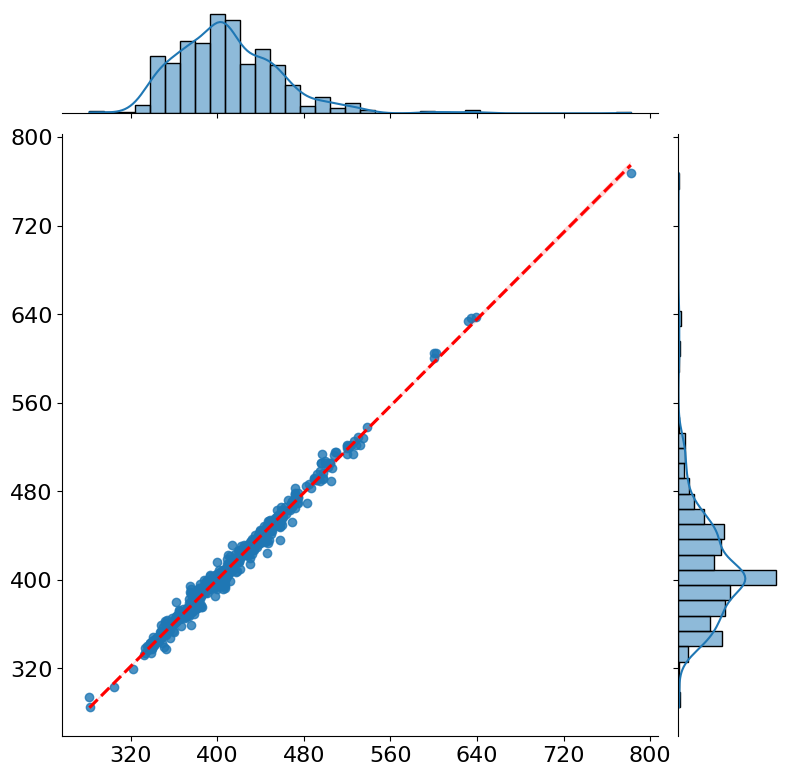

In [22]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(8, 8))
# Create a DataFrame for the expected and predicted values
results_df = DataFrame({'Expected': Y_clean, 'Predicted': y_preditos})

# Create the joint plot with a red regression line
joint_plot = sns.jointplot(x='Expected', y='Predicted', data=results_df, kind='reg', height=8, line_kws={'color': 'red', 'linestyle': '--'})

# Set the number of ticks on x and y axes to 8
joint_plot.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=8))
joint_plot.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=8))

# Make the x and y numbers bigger
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=16)

# Remove x and y labels
joint_plot.set_axis_labels('', '')

# Save the image
plt.savefig('XGB_scatter_max_abs.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
pickle.dump(model_pred, open('xgb_kf_max_em.pkl', 'wb'))